In [ ]:
!conda config --add channels conda-forge
!conda install -y fenics

# Eigenvalue solver

In [ ]:
from fenics import *
from dolfin import *
import math
import numpy as np
    
moduli = [70e9]    

# Create n different materials
class K(Expression):
    def set_k_values(self, k_array):
        self.k_array = k_array
    def eval(self, value, x):
        # Cantilever is split into n materials serially along length
        index = math.floor(x[0]*len(self.k_array))
        value[0] = self.k_array[int(index)]

# Initialize kappa
kappa = K(degree=0)
kappa.set_k_values(moduli)

# Scaled variables
L = 1 # Length
W = 0.02 # Width

Young = kappa
poisson = 0.3

lambda_ = Young * poisson / ((1 + poisson) * (1 - 2*poisson))
mu = Young / (2 * (1 + poisson))

rho = 2700

# Create mesh and define function space
mesh = BoxMesh(Point(0, 0, 0), Point(L, W, W), 100, 3, 3)
V = VectorFunctionSpace(mesh, 'P', 1)

# Define boundary condition
tol = 1E-14

def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < tol

bc = DirichletBC(V, Constant((0, 0, 0)), clamped_boundary)

# Define strain and stress
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    #return sym(nabla_grad(u))

def sigma(u):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

# Define variational problem
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
#f = Constant((0, 0, -rho*g))
T = Constant((0, 0, 0))
a = inner(sigma(u), epsilon(v))*dx
#L = dot(f, v)*dx + dot(T, v)*ds

# Assemble stiffness form
A = PETScMatrix()
assemble(a, tensor=A)

# Create eigensolver
eigensolver = SLEPcEigenSolver(A)

# Compute all eigenvalues of A x = \lambda x
print("Computing eigenvalues. This can take a minute.")
#eigensolver.parameters['spectrum'] = 'smallest real'
eigensolver.solve(15)
#eigensolver.get_eigenvalue(1)

# Extract largest (first) eigenpair
eigens = []
for i in range(15):
    eigens.append(eigensolver.get_eigenpair(i + 1))
    
for i in range(len(eigens)):
    print("Eigenvalue", i, ": ", eigens[i][0], " | Frequency", i, ": ", np.sqrt(eigens[i][0]))
    


# Displacement

In [15]:
"""
FEniCS tutorial demo program: Linear elastic problem.

  -div(sigma(u)) = f

The model is used to simulate an elastic beam clamped at
its left end and deformed under its own weight.
"""

from fenics import *
from dolfin import *
import math
import numpy as np

def run_solver(moduli):
    
    # Create n different materials
    class K(Expression):
        def set_k_values(self, k_array):
            self.k_array = k_array
        def eval(self, value, x):
            # Cantilever is split into n materials serially along length
            index = math.floor(x[0]*len(self.k_array))
            value[0] = self.k_array[int(index)]
            
    # Initialize kappa
    kappa = K(degree=0)
    kappa.set_k_values(moduli)
    
    # Scaled variables
    L = 1 # Length
    W = 0.2 # Width
    
    Young = kappa
    poisson = 0.3
    
    lambda_ = Young * poisson / ((1 + poisson) * (1 - 2*poisson))
    mu = Young / (2 * (1 + poisson))
    
    rho = 2.7e3
    g = 9.8
    
    # Create mesh and define function space
    mesh = BoxMesh(Point(0, 0, 0), Point(L, W, W), 100, 3, 3)
    V = VectorFunctionSpace(mesh, 'P', 1)
    
    # Define boundary condition
    tol = 1E-14
    
    def clamped_boundary(x, on_boundary):
        return on_boundary and x[0] < tol
    
    bc = DirichletBC(V, Constant((0, 0, 0)), clamped_boundary)
    
    # Define strain and stress
    def epsilon(u):
        return 0.5*(nabla_grad(u) + nabla_grad(u).T)
        #return sym(nabla_grad(u))
    
    def sigma(u):
        return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)
    
    # Define variational problem
    u = TrialFunction(V)
    d = u.geometric_dimension()  # space dimension
    v = TestFunction(V)
    f = Constant((0, 0, -rho*g))
    T = Constant((0, 0, 0))
    a = inner(sigma(u), epsilon(v))*dx
    L = dot(f, v)*dx + dot(T, v)*ds
    
    # Compute solution
    u = Function(V)
    solve(a == L, u, bc)
    
    # Save solution
    #vtkfile = File('poisson/solution.pvd')
    #vtkfile << u
    
    # Compute magnitude of displacement
    V = FunctionSpace(mesh, 'P', 1)
    u_magnitude = sqrt(dot(u, u))
    u_magnitude = project(u_magnitude, V)
    #plot(u_magnitude, 'Displacement magnitude')
    #print('min/max u:',
    #      u_magnitude.vector().get_local().min(),
    #      u_magnitude.vector().get_local().max())
    #import matplotlib
    vertical = u_magnitude.vector().get_local()[::4]
    #matplotlib.pyplot.plot(-vertical)
    
    return vertical


def get_fitness(moduli, target):
    deflections = run_solver(moduli)
    interestPoints = [deflections[0], deflections[100], deflections[200], deflections[300], deflections[400]]
    differences = np.subtract(interestPoints, target)
    fitness = np.linalg.norm(differences)
    
    return fitness

-5.89504728071e-06
0.0908443021264
0.206902659139
0.330447429145
0.460917666377


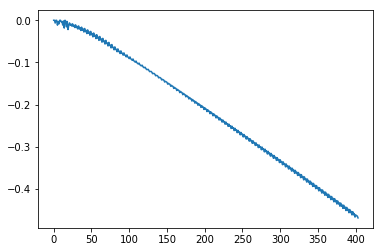

In [46]:
deflections = run_solver([1e6, 1e7, 1e8, 1e7, 1e6])

print(deflections[0])
print(deflections[100])
print(deflections[200])
print(deflections[300])
print(deflections[400])

import matplotlib.pyplot as plt
plt.plot(-deflections)

# Heuristics

In [47]:
# Presolved target
def get_fitness_wrapper(moduli):
    target = [0, 0.09, 0.20, 0.33, 0.46]
    
    return get_fitness(moduli, target)

fitness = get_fitness_wrapper([1e6, 1e7, 1e8, 1e7, 1e6])
print("Fitness =", fitness)

Fitness = 0.00702864769683


### SciPy heuristics

In [54]:
import scipy.optimize

bounds = [(1e6, 1e8), (1e6, 1e8), (1e6, 1e8), (1e6, 1e8), (1e6, 1e8)]
bounds_tuple = ((1e6, 1e8), (1e6, 1e8), (1e6, 1e8), (1e6, 1e8), (1e6, 1e8))

np.set_printoptions(formatter={'float': lambda x: format(x, '.2E')})

#### Differential evolution

In [57]:
solution = scipy.optimize.differential_evolution(get_fitness_wrapper, bounds, maxiter=10, popsize=15)

print("Solution =", solution.x)
print("Objective function (min) =", solution.fun)
print("Function evaluations =", solution.nfev)

Solution = [1.08E+06 7.68E+06 5.01E+06 5.74E+07 1.97E+07]
Objective function (min) = 0.0189115978951
Function evaluations = 897


#### Basin hopping

In [ ]:
# ???
solution = scipy.optimize.basinhopping(get_fitness_wrapper, x0 = [1e7, 1e7, 1e7, 1e7, 1e7], niter=3, T= 0.1, stepsize= 1e7)

print("Solution =", solution.x)
print("Objective function (min) =", solution.fun)
print("Function evaluations =", solution.nfev)

#### Brute force

In [55]:
gridpoints = 4

solution = scipy.optimize.brute(get_fitness_wrapper, ranges = bounds_tuple, Ns = gridpoints, full_output=True, finish=None)

print("Solution =", solution[0])
print("Objective function (min) =", solution[1])
print("Function evaluations =", gridpoints**5)

Solution = [1.00E+06 3.40E+07 3.40E+07 1.00E+06 1.00E+08]
Objective function (min) = 0.00431771909604
Function evaluations = 1024


### DEAP heuristics

In [ ]:
!pip install deap

In [75]:
import array
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("attr_float", random.uniform, 1e6, 1e8)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    return get_fitness_wrapper(individual),

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1e7, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
    
pop = toolbox.population(n=15)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, 
                               stats=stats, halloffame=hof, verbose=False)

print(log)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	std        	min     	max     
0  	15    	0.564619	0.0473579  	0.415095	0.592952
1  	1     	0.53086 	0.0632693  	0.415095	0.585933
2  	12    	0.494846	0.0697239  	0.361255	0.592785
3  	9     	0.430488	0.0524562  	0.361255	0.54414 
4  	9     	0.393603	0.0253354  	0.361255	0.415806
5  	7     	0.386152	0.0251722  	0.361255	0.414957
6  	3     	0.369162	0.0170733  	0.361255	0.412575
7  	6     	0.364806	0.0127761  	0.361255	0.412575
8  	6     	0.358829	0.0095979  	0.322962	0.363196
9  	6     	0.353591	0.0153141  	0.322962	0.361255
10 	9     	0.343384	0.0190933  	0.322962	0.361255
11 	12    	0.330624	0.0152926  	0.322948	0.361209
12 	10    	0.334124	0.0412554  	0.322948	0.488478
13 	9     	0.322941	5.29845e-05	0.322745	0.322962
14 	11    	0.322887	0.000183055	0.322229	0.322948
15 	9     	0.323203	0.0018556  	0.322229	0.330052
16 	8     	0.324927	0.00915387 	0.322229	0.359165
17 	5     	0.322304	0.000224512	0.322229	0.323113
18 	6     	0.334025	0.0440712  	0.322229	0.498924
